In [47]:
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
from astroML.stats import binned_statistic
import matplotlib.pyplot as plt

In [33]:
from m31hst.phatast import load_phat_ast_table
t = load_phat_ast_table()

In [34]:
km = KMeans(n_clusters=6)
xy = np.vstack((t['ra'], t['deg'])).T
km.fit(xy)
centers = km.cluster_centers_
print centers

[[ 10.80073952  41.31165493]
 [ 11.55581084  42.14674574]
 [ 11.15978774  41.63931688]
 [ 10.87125638  41.45011536]
 [ 10.68679924  41.30852815]
 [ 10.70681719  41.26110849]]


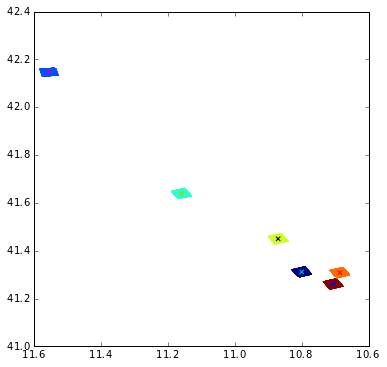

In [51]:
colors = ['c', 'm', 'y', 'k', 'r', 'b']

figure = plt.figure(figsize=(6, 6))
ax = figure.add_subplot(111)
ax.scatter(t['ra'], t['deg'],
           marker='.', edgecolors='None', s=1,
           c=km.labels_, rasterized=True)
ax.scatter(centers[:, 0], centers[:, 1],
           marker='x', s=20, c='None',
           edgecolors=colors, zorder=10)
ax.set_xlim(11.6, 10.6)
figure.show()

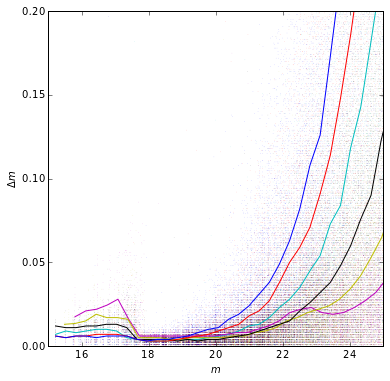

In [53]:
f2 = plt.figure(figsize=(6, 6))
ax = f2.add_subplot(111)
for label, c in zip(range(6), colors):
    sel = np.where(km.labels_ == label)[0]
    tt = t[sel]
    diffs = np.abs(tt['f475w_in'] - tt['f475w_out'])
    s = np.where(diffs < 10.)[0]
    err, edges = binned_statistic(tt['f475w_in'][s],
                                  diffs[s],
                                  statistic='median', bins=50)
    ax.scatter(tt['f475w_in'][::2], diffs[::2],
               s=1, marker='.', alpha=0.4,
               edgecolors='None', facecolors=c)
    ax.plot(edges[:-1], err, ls='-', c=c)
ax.set_xlabel(r'$m$')
ax.set_ylabel(r'$\Delta m$')
ax.set_ylim(0, 0.2)
ax.set_xlim(15., 25.)
f2.show()
        

/Users/jsick/.virtualenvs/androphot/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide


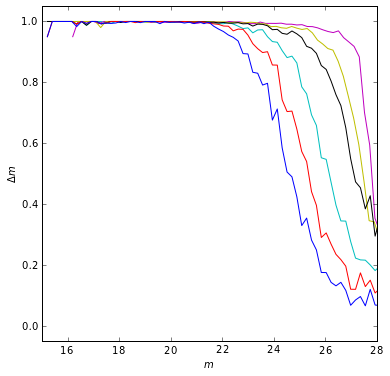

In [72]:
f3 = plt.figure(figsize=(6, 6))
ax = f3.add_subplot(111)
n_bins = 80
for label, c in zip(range(6), colors):
    sel = np.where(km.labels_ == label)[0]
    tt = t[sel]
    dropped = np.where(tt['f475w_out'] >= 90.)[0]
    drop_flag = np.ones(len(tt), dtype=np.float)
    drop_flag[dropped] = 0.
    total_recovered, edges = binned_statistic(tt['f475w_in'],
                                              drop_flag,
                                              statistic='sum',
                                              bins=n_bins)
                                              # range=np.array([15., 28.]))
    count, edges = binned_statistic(tt['f475w_in'],
                                    drop_flag,
                                    statistic='count',
                                    bins=n_bins)
                                    # range=np.array([15., 28.]))
    ax.plot(edges[:-1], total_recovered / count, ls='-', c=c)
ax.set_xlabel(r'$m$')
ax.set_ylabel(r'$\Delta m$')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(15., 28.)
f3.show()